     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 12.4 MB/s eta 0:00:00


/tmp/ipython-input-1-1266407515.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1-1266407515.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1-1266407515.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1-1266407515.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1-126

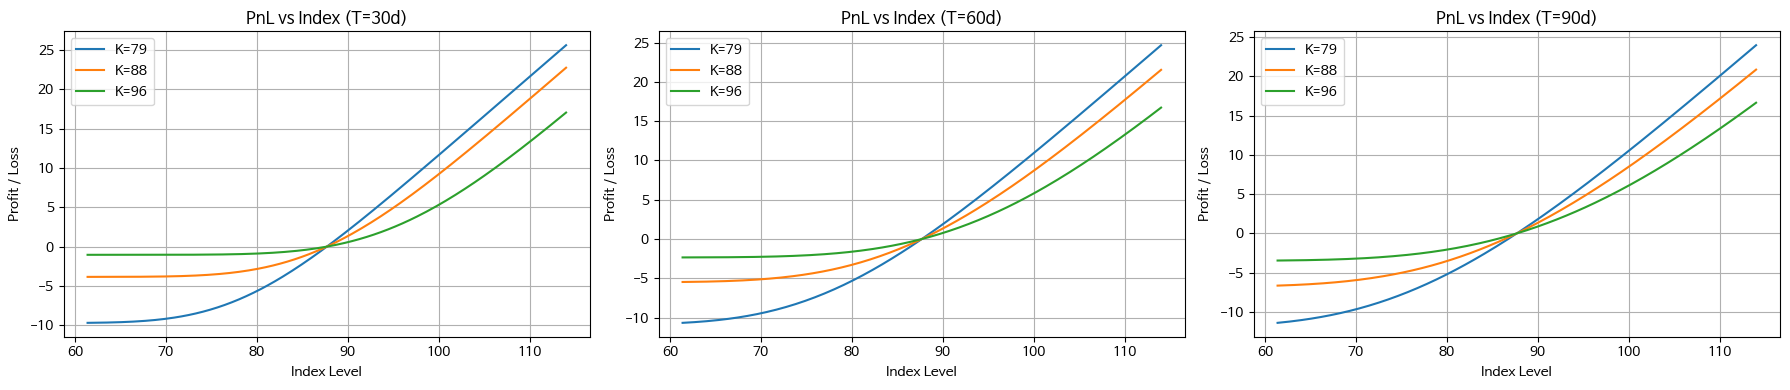

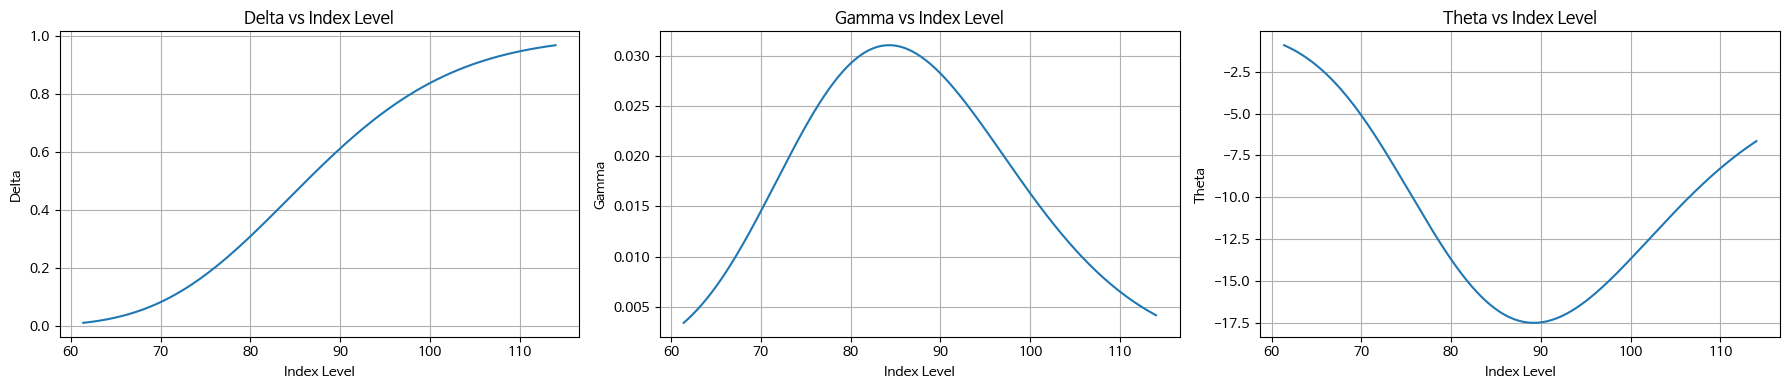

/tmp/ipython-input-1-1266407515.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/tmp/ipython-input-1-1266407515.py:74: RuntimeWarning: invalid value encountered in scalar divide
  gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
/tmp/ipython-input-1-1266407515.py:75: RuntimeWarning: invalid value encountered in scalar divide
  theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
/tmp/ipython-input-1-1266407515.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/tmp/ipython-input-1-1266407515.py:71: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/tmp/ipython-input-1-1266407515.py:72: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
/tmp/ipython-input-1-1266

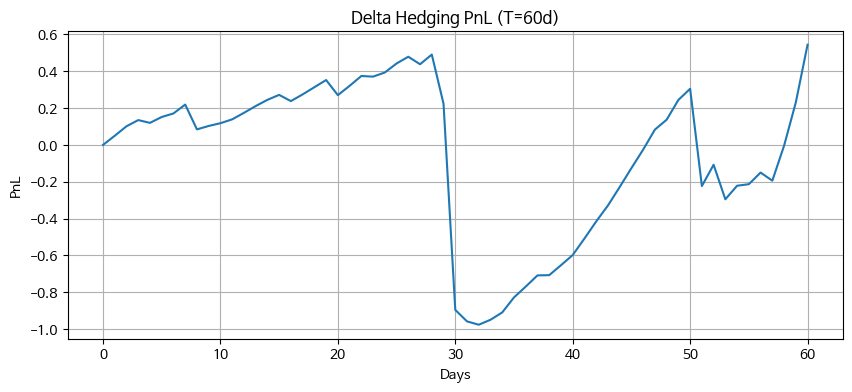

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Deep Learning Option Price Approximation MSE (real data): 13.8105


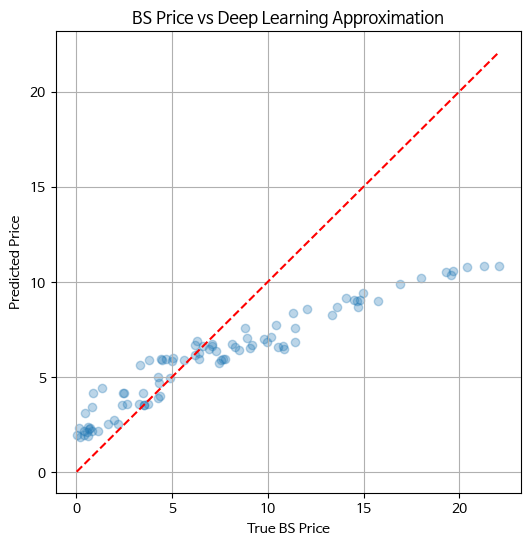

In [1]:
!pip install yfinance pykrx matplotlib scikit-learn tensorflow --quiet

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pykrx import stock
from datetime import datetime, timedelta
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras

# 1. 날짜 설정
end = datetime.today()
start = end - timedelta(days=365)

# 2. 종목 설정
stocks = {
    "이오테크닉스": "039030.KQ",
    "삼성전기": "009150.KS",
    "SKC": "011790.KS",
    "필옵틱스": "161580.KQ",
    "주성엔지니어링": "036930.KQ",
    "기가비스": "282330.KQ",
    "와이씨켐": "298540.KQ",
    "켐트로닉스": "089010.KQ",
    "유티아이": "179900.KQ",
    "HB테크놀러지": "078150.KQ"
}

# 3. 주가 데이터 수집
price_df = pd.DataFrame()
for name, ticker in stocks.items():
    df = yf.download(ticker, start=start, end=end)["Close"]
    price_df[name] = df

price_df = price_df.fillna(method="ffill").dropna()

# 4. 시가총액 가중 평균 계산
latest_date = price_df.index[-1].strftime("%Y%m%d")
market_caps = {}
cap_data = stock.get_market_cap_by_ticker(latest_date)
for name in stocks:
    code = stocks[name][:6]
    market_caps[name] = cap_data.loc[code, "시가총액"]

total_cap = sum(market_caps.values())
weights = {k: v / total_cap for k, v in market_caps.items()}

# 5. 유리기판 산업지수 계산 및 정규화
index_series = price_df.copy()
for col in index_series.columns:
    index_series[col] *= weights[col]
index = index_series.sum(axis=1)
index = index / index.iloc[0] * 100

# 6. 변동성 추정 (realized volatility)
returns = index.pct_change().dropna()
realized_vol = returns.rolling(21).std() * np.sqrt(252)
latest_sigma = realized_vol.iloc[-1]

# 7. 옵션 가격 및 Greeks 계산 (다양한 K, T)
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    return delta, gamma, theta

# 8. 시나리오 분석용 변수 설정
S0 = index.iloc[-1]
K_list = [S0 * x for x in [0.9, 1.0, 1.1]]
T_list = [30/365, 60/365, 90/365]
r = 0.035

option_matrix = pd.DataFrame()

# 9. 선 그래프로 Profit/Loss 시각화
S_range = np.linspace(S0 * 0.7, S0 * 1.3, 200)
fig_pl, ax_pl = plt.subplots(1, len(T_list), figsize=(18, 4))

for i, T in enumerate(T_list):
    for K in K_list:
        pl = [black_scholes_call(S, K, T, r, latest_sigma) - black_scholes_call(S0, K, T, r, latest_sigma) for S in S_range]
        ax_pl[i].plot(S_range, pl, label=f"K={K:.0f}")
    ax_pl[i].set_title(f"PnL vs Index (T={int(T*365)}d)")
    ax_pl[i].set_xlabel("Index Level")
    ax_pl[i].set_ylabel("Profit / Loss")
    ax_pl[i].legend()
    ax_pl[i].grid(True)

plt.tight_layout()
plt.show()

# 10. Greeks 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
deltas, gammas, thetas = [], [], []

for S in S_range:
    delta, gamma, theta = bs_greeks(S, S0, 60/365, r, latest_sigma)
    deltas.append(delta)
    gammas.append(gamma)
    thetas.append(theta)

axes[0].plot(S_range, deltas)
axes[0].set_title("Delta vs Index Level")
axes[0].set_xlabel("Index Level")
axes[0].set_ylabel("Delta")
axes[0].grid(True)

axes[1].plot(S_range, gammas)
axes[1].set_title("Gamma vs Index Level")
axes[1].set_xlabel("Index Level")
axes[1].set_ylabel("Gamma")
axes[1].grid(True)

axes[2].plot(S_range, thetas)
axes[2].set_title("Theta vs Index Level")
axes[2].set_xlabel("Index Level")
axes[2].set_ylabel("Theta")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 11. 델타 헷징 시뮬레이션
def delta_hedge_sim(index, K, T_days, r, sigma):
    T = T_days / 365
    dt = 1 / 252
    cash = 0
    shares = 0
    pnl_list = []

    for i in range(len(index) - T_days):
        S = index.iloc[i]
        t = (T_days - i) / 252
        delta, _, _ = bs_greeks(S, K, t, r, sigma)
        if i == 0:
            shares = delta
            cash = black_scholes_call(S, K, t, r, sigma) - shares * S
        else:
            delta_new, _, _ = bs_greeks(S, K, t, r, sigma)
            shares_diff = delta_new - shares
            cash -= shares_diff * S
            shares = delta_new
        portfolio = shares * S + cash
        pnl = portfolio - black_scholes_call(S, K, t, r, sigma)
        pnl_list.append(pnl)

    return pnl_list

pnl_result = delta_hedge_sim(index, K=S0, T_days=60, r=r, sigma=latest_sigma)
plt.figure(figsize=(10, 4))
plt.plot(pnl_result)
plt.title("Delta Hedging PnL (T=60d)")
plt.xlabel("Days")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

# 12. 딥러닝 기반 옵션 가격 근사 (현실 지수 기반)
X, y = [], []
for i in range(len(index)-90):
    for T_days in [30, 60, 90]:
        S = index.iloc[i]
        K = S0
        T = T_days / 365
        sigma = realized_vol.iloc[i] if not np.isnan(realized_vol.iloc[i]) else latest_sigma
        price = black_scholes_call(S, K, T, r, sigma)
        X.append([S, K, T, r, sigma])
        y.append(price)

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)

pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
print(f"Deep Learning Option Price Approximation MSE (real data): {mse:.4f}")

# 13. 예측값 vs 실제값 비교 시각화
plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True BS Price")
plt.ylabel("Predicted Price")
plt.title("BS Price vs Deep Learning Approximation")
plt.grid(True)
plt.show()
